## **1. Loading dependencies modules**

In [1]:
import pandas as pd
import torch
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

#Conformation generation
from conformation_encode.generate_conformations import generate_conformations, visualize_conformations
from conformation_encode.Draw_mol_utils import show_mol, show_images

#Creating Graph dataset
from conformation_encode.GraphDataset import BagMoleculeDataset, InstanceMoleculeDataset, MoleculeDataset 

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Torch version: 2.2.0
Torch geometric version: 2.4.0


## **2. Generating multiple conformations**

In this exemple, I am going to generate multiple conformations of **Isonitrile* by `generate_conformations` module.   

### *2.1. Module information*

In [2]:
print(generate_conformations.__doc__)


    Generate number of conformations for a molecule by using ETKDG version 3 algorithm and 
    MMFF force field to optimize the conformations.

    Parameters
    ----------
    mol : RDKit molecule object
        The molecule for which the conformations are to be generated.
    num_confs : int
        The number of conformations to be generated.
    rmsd : float, optional
        The RMSD value to be used to remove similar conformations. The default is 0.5.
    energy : float, optional
        The energy value to be used to remove conformations with high energy. The default is 10.
    seed : int, optional
        The seed value for the random number generator. The default is 42.
    num_threads : int, optional 
        The number of threads to be used for the ETKDG algorithm. The default is 8.
    max_attemp : int, optional
        The maximum number of attempts to generate the conformations. The default is 1000.
    Returns
    -------
    mol : RDKit molecule object
        The mo

### *2.2. Conformations generations*

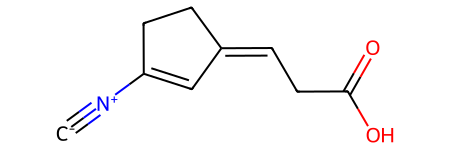

In [3]:
# Load dataset
data = pd.read_csv("./data/Official/cdr1_binary_0902.csv")

#  Conformation generation
smiles = data["Canonicalsmiles"][0]
isonitrile = Chem.MolFromSmiles(smiles)
display(isonitrile)
# Generate conformations
confs = generate_conformations(mol = isonitrile, num_confs = 10, rmsd = 0.5,seed= 42, energy = 10, max_attemp = 1000, num_threads = -1)
mol, cids = confs.gen_confs()

### *2.3. Analyze results*

In [4]:
#Visualize conformations
from itertools import combinations

print(f'Remove {len(confs.remove_ids)} conformations')
print(f"Number of remain conformations: {len(cids)}")

# Print energy of each conformation
print("Energy of each conformation")
for conf in mol.GetConformers():
    ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol), confId=conf.GetId())
    print(f"Conformation {conf.GetId()} energy: {ff.CalcEnergy()}")

# Print RMSD between each pair of conformations
print("#" * 50)
print("RMSD between each pair of conformations")

for confid1, confid2 in combinations(cids, 2):
    
    print(f"RMSD between conf{confid1} and conf{confid2} is {AllChem.GetConformerRMS(mol, confid1, confid2)}")

visualize_conformations(mol, cids)


Remove 0 conformations
Number of remain conformations: 10
Energy of each conformation
Conformation 0 energy: 5.635141911066638
Conformation 1 energy: 5.6351421312274725
Conformation 2 energy: 4.598736533580192
Conformation 3 energy: 5.6351419120288995
Conformation 4 energy: 4.598736534092778
Conformation 5 energy: 5.6351419110733465
Conformation 6 energy: 5.635141911348032
Conformation 7 energy: 4.59873653359911
Conformation 8 energy: 5.6351419111351175
Conformation 9 energy: 4.598736536863987
##################################################
RMSD between each pair of conformations
RMSD between conf0 and conf1 is 0.5482339243641519
RMSD between conf0 and conf2 is 1.8842558010937875
RMSD between conf0 and conf3 is 0.7762716446798418
RMSD between conf0 and conf4 is 1.4568075672040368
RMSD between conf0 and conf5 is 1.2028865409797196
RMSD between conf0 and conf6 is 1.3589510139420897
RMSD between conf0 and conf7 is 1.9529770573561434
RMSD between conf0 and conf8 is 0.9503473279889961
RM

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## **3. Dataset**

Our approach for this project is **Multi-instance learning** inspired from [*QSAR Modeling Based on Conformation Ensembles Using a Multi-Instance Learning Approach*](https://pubs.acs.org/doi/10.1021/acs.jcim.1c00692) paper.
Therefore, I designed 2 pipeline to create 2 type of Graph dataset:
- Instance Graph Dataset
- Bag Graph Dataset 

### *3.1. Instance Dataset*

Instance dataset stores individual conformations of each molecule as separate data points and the corresponding labels based of the activity of the molecule. I created `InstanceMoleculeDataset` to create Instance dataset. These are key characteristics of my module:
- Data source:
    - `root`: Root directory: "./data_cdr1_instance_test/"
    - `filename`: Filename: "cdr1_binary.csv"
    - `data`: csv file contains 3 columns: ID, SMILES, and Activity
- Features:
    - Extracts node and edge features from each molecular graph (conformation).
    - Optionally incorporates 3D spatial information and atomic shape details.
    - Handles multiple conformations per molecule, storing each as a separate data point.
- Hyperparameters:
    - `cut_off`: Distance cutoff for spatial features (default: 3.5).
    - `num_confs`: Number of conformations generated per molecule (default: 10).
    - `seed`: Random seed for RDKit conformer generation (default: 42).
    - `rmsd`: Root mean square deviation threshold for conformer selection (default: 0.5).
    - `energy`: Energy threshold for conformer selection (default: 10).
    - `max_attemp`: Maximum attempts for conformer generation (default: 1000).
    - `num_threads`: Number of threads for RDKit computations (default: -1, uses all available cores).
    - Columns used:
        - `smiles_col`: Column name containing SMILES strings for molecules (default: "Canonicalsmiles").
        - `activity_col`: Column name containing activity labels (default: "Activity").
- **Purpose**: This dataset is specifically designed for training and evaluating **InstanceNet** models, which analyze individual conformations of molecules. It provides the necessary features and structure for the model to learn relationships between atomic properties, spatial arrangements, and molecular activity within each conformation.

In [5]:
#TEST WITH THE FIRST 10 MOLECULES IN ORIGINAL DATASET
data_test = data.iloc[:10,:]
instancedataset = InstanceMoleculeDataset(root = "./data_cdr1_instance_test/",
                            filename = "cdr1_binary.csv",
                            data = data_test, smiles_col = "Canonicalsmiles", activity_col = "Activity",
                            cut_off = 3.5, num_confs = 10, seed = 42, rmsd = 0.5, 
                            energy =10, max_attemp = 1000, num_threads = -1)

The dataset resides in the `data_cdr1_instance_test` folder, which has three subfolders: `raw`, `processed`, and `processed_conformations_instances`.

* **`raw`**: This folder stores the original data file in *.csv format.
* **`processed`**: This folder contains preprocessed data files in *.pt format. These files encapsulate graph data encoded from the various molecular conformations.
* **`processed_conformations_instances`**: This folder holds individual conformations saved as *.sdf files.

It's important to note that this dataset creation process only needs to be executed once. Thereafter, we can effortlessly load the prepared dataset for subsequent usage.

Each data sample incorporates features readily obtainable for Graph Neural Networks (GNNs). Let's use the first data sample, representing the first conformation of Isonitrile, as an example:

* **`edge_index`:** This defines the connections between nodes in the graph, representing **42 chemical bonds** in Isonitrile.
* **`y`:** This label indicates whether Isonitrile is an active compound in the dataset (assuming "1" is activity and "0" is inactive).
* **`pos`:** This encodes the **3D coordinates** of all **21 atoms** in Isonitrile.
* **`node_features_2d`:** Each of the **21 nodes** has **10 2D node features**.
* **`edge_attr_2d`:** Each of the **42 edges** has **5 2D edge features**.
* **`node_features_3d`:** Each of the **21 nodes** has **8 3D node features**.
* **`edge_attr_3d`:** Each of the **42 edges** has **8 3D edge features**.
* **`smiles`:** This encodes the molecular structure of Isonitrile using the SMILES string.
* **`conf_id`:** This unique identifier specifies that this is the **first conformation** among potentially multiple generated conformations for Isonitrile.

In [6]:
instancedataset[0]

Data(edge_index=[2, 120], y=[1], pos=[55, 3], node_features_2d=[55, 10], edge_attr_2d=[120, 5], node_features_3d=[55, 8], edge_attr_3d=[120, 8], smiles='c1ccc(-c2nc3ccccc3n3c(N4CCN(c5ccccc5)CC4)ccc23)cc1', conf_id=0)

### *3.1. Bag Dataset*

My `BagMoleculeDataset` module creates **BagDatasets**, a specific format to store **multiple conformations** for each molecule. Each "bag" containing these conformations represents a single data sample. This approach is similar to `InstanceMoleculeDataset` in principle, but differs in the **data sample structure**: bags vs. individual conformations. I'll explain the detailed structure of each data sample later.


In [7]:
data_test = data.iloc[:10,:]
bagdataset = BagMoleculeDataset(root = "./data_cdr1_bag/",
                            filename = "cdr1_binary.csv",
                            data = data_test, smiles_col = "Canonicalsmiles", activity_col = "Activity",
                            cut_off = 3.5, num_confs = 10, seed = 42, rmsd = 0.5, 
                            energy =10, max_attemp = 1000, num_threads = -1)

The dataset resides in the `data_cdr1_bag_test` folder, which has three subfolders: `raw`, `processed`, and `processed_conformations_bag`.

* **`raw`**: This folder stores the original data file in *.csv format.
* **`processed`**: This folder contains preprocessed data files in *.pt format. These files encapsulate graph data encoded from the **bag** containing various molecular conformations.
* **`processed_conformations_instances`**: This folder holds individual conformations saved as *.sdf files.

It's important to note that this dataset creation process only needs to be executed once. Thereafter, we can effortlessly load the prepared dataset for subsequent usage.

In [8]:
bagdataset[0]

Data(y=[1], instance_data=[10], smiles='[C-]#[N+]C1=CC(=CCC(=O)O)CC1', num_instances=10)

Each data sample represents a "Bag" and incorporates the following features:

* **`y`:** This label indicates whether the molecule in the Bag is active (assuming "1" signifies activity and "0" inactivity).
* **`instance_data`:** This is a list of Graph DataSets, each holding features for a single conformation within the Bag. In this example, the Bag for Isonitrile contains 10 Graph DataSets (one for each of the 10 generated conformations) since no conformations were removed based on the RMSD and energy thresholds.
* **`smiles`:** This encodes the canonical SMILES string of the molecule represented by the Bag.
* **`num_instances`:** This value specifies the number of conformations (Graph DataSets) included in the Bag. In this case, the Isonitrile Bag contains 10 instances.

Each instance in a Bag represents a single conformation of the molecule and is encoded as a graph dataset holding the same features described earlier.

In [9]:
bagdataset[0].instance_data

[Data(edge_index=[2, 42], y=[1], pos=[21, 3], node_features_2d=[21, 10], edge_attr_2d=[42, 5], node_features_3d=[21, 8], edge_attr_3d=[42, 8], smiles='[C-]#[N+]C1=CC(=CCC(=O)O)CC1', conf_id=0),
 Data(edge_index=[2, 42], y=[1], pos=[21, 3], node_features_2d=[21, 10], edge_attr_2d=[42, 5], node_features_3d=[21, 8], edge_attr_3d=[42, 8], smiles='[C-]#[N+]C1=CC(=CCC(=O)O)CC1', conf_id=1),
 Data(edge_index=[2, 42], y=[1], pos=[21, 3], node_features_2d=[21, 10], edge_attr_2d=[42, 5], node_features_3d=[21, 8], edge_attr_3d=[42, 8], smiles='[C-]#[N+]C1=CC(=CCC(=O)O)CC1', conf_id=2),
 Data(edge_index=[2, 42], y=[1], pos=[21, 3], node_features_2d=[21, 10], edge_attr_2d=[42, 5], node_features_3d=[21, 8], edge_attr_3d=[42, 8], smiles='[C-]#[N+]C1=CC(=CCC(=O)O)CC1', conf_id=3),
 Data(edge_index=[2, 42], y=[1], pos=[21, 3], node_features_2d=[21, 10], edge_attr_2d=[42, 5], node_features_3d=[21, 8], edge_attr_3d=[42, 8], smiles='[C-]#[N+]C1=CC(=CCC(=O)O)CC1', conf_id=4),
 Data(edge_index=[2, 42], y=[1